In [10]:
import numpy as np
import pandas as pd
import scanpy as sc
from cellpose import models, io, plot
import matplotlib.pyplot as plt
from tqdm import tqdm

In [9]:
def rgb2grey(img: np.ndarray):
    return np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
class Const:
    PIX_X = 'X'
    PIX_Y = 'Y'

In [144]:
def predict_cell_num(st_adata_path,
                     crop_r,
                     save_png_result=None,
                     model_type='cyto3', 
                     cellprob_threshold=1):
    '''
    Params
    -----
    img_path: str, WSI. size can be arbitrary.
    spot_path: str. csv/tsv file contains the spot pixel coordinates.
    crop_r: the length of the tile. each tile will be a square.
    save_png_result: None or str, if None, do not save the segmentation result to a png file; otherwise, save the png to the provided file path name.

    Returns
    -----
    a pd.Dataframe with 'X', 'Y', 'cell_num' columns.
    '''

    print('-----Initializing model...')
    model = models.Cellpose(model_type=model_type)
    ch = [0, 0] # NOTE: here we set all images to greyscale
    st_adata = sc.read_h5ad(st_adata_path)

    print('-----Reading files...')
    img = rgb2grey(st_adata.uns['spatial']['library_ids']['images']['hires'])
    coord = st_adata.obsm['spatial']*st_adata.uns['spatial']['library_ids']['scalefactors']['tissue_hires_scalef']
    spots = pd.DataFrame(coord, columns=["X", "Y"])
    half_r = crop_r // 2
    
    print('-----Predicting cell number...')
    ret = pd.DataFrame(data={'X':[], 'Y':[], 'cell_num':[]})
    cell_pos = pd.DataFrame(data={'id':[], 'X':[], 'Y':[]})
    for _, row in tqdm(spots.iterrows()):
        x = int(row[Const.PIX_X]); y = int(row[Const.PIX_Y])
        tile = img[x-half_r:x+half_r, y-half_r:y+half_r]
        masks, flows, styles, diams = model.eval(tile, diameter=None, channels=ch,  cellprob_threshold=cellprob_threshold)
        cell_num = len(np.unique(masks))
        ret.loc[len(ret.index)] = [x, y, cell_num]
        for i in range(cell_num):
            xi = np.where(masks == i)[0].mean()
            yi = np.where(masks == i)[1].mean()
            cell_pos.loc[len(cell_pos.index)] = [f"spot{_}_cell{i}", xi, yi]
        
        if save_png_result:
            fig = plt.figure()
            plot.show_segmentation(fig, tile, masks, flows[0], channels=ch)
            plt.tight_layout()
            plt.savefig(save_png_result.replace('.', f'_{x}x{y}.'))

    st_adata.obsm["cell_num"] = (ret["cell_num"]).to_numpy()
    st_adata.uns["seg_cell_pos"] = cell_pos
    return st_adata, cell_pos

In [145]:
crop_r = 224
st_adata_path = "../../draft/st_adata.h5ad"
ret, cell_pos = predict_cell_num(
                st_adata_path,
                crop_r,
                save_png_result=None,
                model_type='cyto3', 
                cellprob_threshold=1)

-----Initializing model...
-----Reading files...
-----Predicting cell number...


0it [00:03, ?it/s]


In [146]:
cell_pos

,id,X,Y
0,spot0_cell0,99.969650,109.013007
1,spot0_cell1,12.047101,91.079710
2,spot0_cell2,14.507874,21.535433
3,spot0_cell3,2.969072,72.371134
4,spot0_cell4,12.818947,113.957895
...,...,...,...
100,spot0_cell100,211.443983,204.070539
101,spot0_cell101,211.510471,45.520942
102,spot0_cell102,211.903297,66.775824
103,spot0_cell103,211.706796,90.386408


In [117]:
ret

,X,Y,cell_num
0,1017,563,105
1,1028,544,117
2,1039,563,108
3,1051,544,114
4,1062,563,106
...,...,...,...
369,1368,1016,1
370,960,1056,1
371,983,1056,1
372,1006,1056,1


In [128]:
st_adata = sc.read_h5ad(st_adata_path)
# st_adata.obsm["cell_num"] = ret["cell_num"]
# st_adata.obsm["cell_num"]
st_adata.obsm["cell_num"] = (ret["cell_num"]).to_numpy()

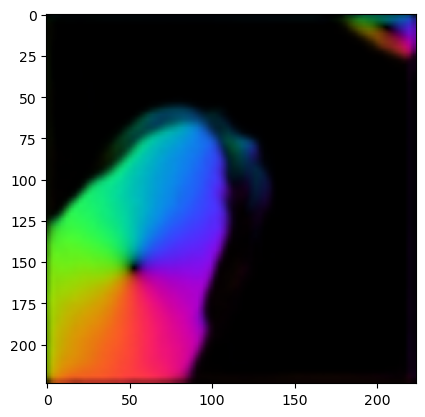

In [29]:
plt.imshow(flows[0])

In [54]:
flows[3]

array([[[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  1.,   1.,   1., ...,   1.,   1.,   1.],
        [  2.,   2.,   2., ...,   2.,   2.,   2.],
        ...,
        [221., 221., 221., ..., 221., 221., 221.],
        [222., 222., 222., ..., 222., 222., 222.],
        [223., 223., 223., ..., 223., 223., 223.]],

       [[  0.,   1.,   2., ..., 221., 222., 223.],
        [  0.,   1.,   2., ..., 221., 222., 223.],
        [  0.,   1.,   2., ..., 221., 222., 223.],
        ...,
        [  0.,   1.,   2., ..., 221., 222., 223.],
        [  0.,   1.,   2., ..., 221., 222., 223.],
        [  0.,   1.,   2., ..., 221., 222., 223.]]], dtype=float32)

In [102]:
np.where(masks == 2)[0].mean(), np.where(masks == 2)[1].mean()

(2.8653846153846154, 70.08653846153847)

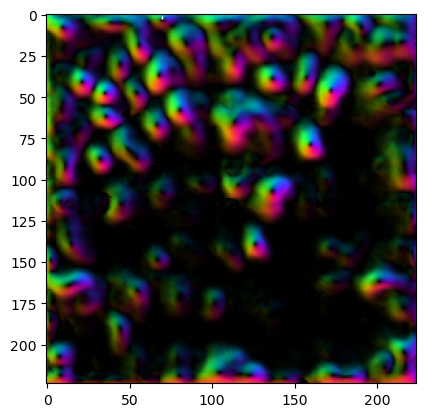

In [112]:
del tmp
tmp = flows.copy()
tmp[0][3][70] = [255, 255, 255]
tmp[0][2][70] = [255, 255, 255]
plt.imshow(tmp[0])